In [3]:
import numpy as np
import numpy.random as rand
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline



In [4]:
def centering(X):
    # X: [m,n]
    m, n = X.shape
    # mathematically
    # return np.dot(np.identity(m) - np.ones([m,m]) / float(m) , X) 
    # prob faster:
    return  X - np.mean(X, axis=0)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def contrast_normalization(X, c=0.2):
    # X: [m,n]
    return X / np.maximum(c, linalg.norm(X, axis=0))
    
def whitening(X, eps=10e-6):
    # X = [m,n]
    # returns transformation for mapping
    # TODO: demean the data
    X = X - np.array([np.mean(X, axis=1)]).T
    covX = np.dot(X,X.T) / len(X)
    
    w, v = linalg.eig(covX)
    w = np.real(w)
    idx = w > eps
    w = np.sqrt(w[idx])
    v = np.real(v[:,idx])

    ## sort by decreasing order of eigen vals
    #     idx = w.argsort()[::-1]
    #     w = w[idx]
    #     v = v[:,idx]
    w_inv = 1 / w 

    transform = np.dot(np.dot(v, np.diag(w_inv)), v.T)
    
    return transform

In [5]:
A = np.array([-1,1,2,3])
A[A > 0]

array([1, 2, 3])

[[1 4 1 2]
 [2 5 5 3]
 [3 6 2 5]]


/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


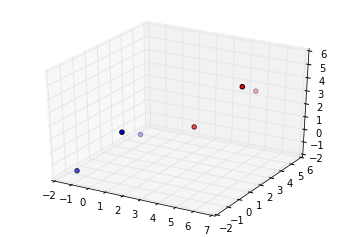

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([[1,2,3],[4,5,6],[1,5,2],[2,3,5]]).T
X_new = centering(X)

print X

ax.scatter(X[:,1],X[:,2],X[:,3],c='r')
ax.scatter(X_new[:,1],X_new[:,2],X_new[:,3],c='b')


In [7]:
import Image
img = Image.open('lena.png').convert('LA')
img.save('greylena.png')

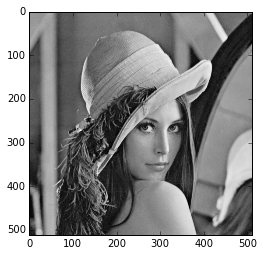

In [11]:
img = mpimg.imread('lena.png')
grey_img = rgb2gray(img)
plt.imshow(grey_img, cmap=plt.get_cmap('gray'))


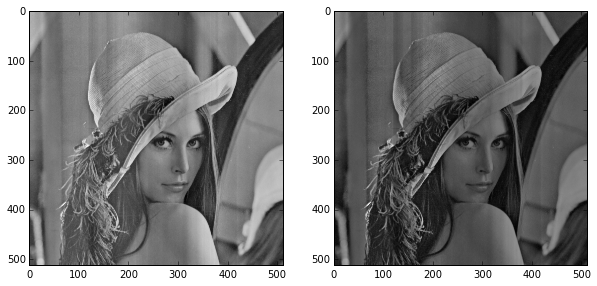

In [12]:
# Centering Globally

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(centering(grey_img), cmap=plt.get_cmap('gray'))

plt.subplot(222)
plt.imshow(contrast_normalization(grey_img), cmap=plt.get_cmap('gray'))


In [16]:
# Centering patches, recombined

def extract_patches(img, patch_shape):
    patches = []    
    for i in xrange(img.shape[0]-patch_shape[0]+1):
        for j in xrange(img.shape[1]-patch_shape[1]+1):
            patch = img[i:i+patch_shape[0], j:j+patch_shape[1]]
            patches.append(patch)
    
    return patches

def assemble_patches(patches, img_shape):
    if len(patches) == 0:
        return
    p0, p1 = patches[0].shape    
    k = 0        
    img = np.zeros(img_shape)
    overlap_ctr = np.zeros(img_shape)
    for i in xrange(img_shape[0]-p0+1):
        for j in xrange(img_shape[1]-p1+1):
            img[i:i+p0, j:j+p1] += patches[k]
            overlap_ctr[i:i+p0, j:j+p1] += 1
            k += 1
    return img / overlap_ctr

def visualise_patches(patches, tile_shape, padding=True):
    '''
    Input:
        patches: N element of [p0, p1] patches
        tile_shape: (t0,t1): t0 rows t1 cols
    '''
    # get dimension of the patch
    p0, p1 = patches[0].shape
    t0, t1 = tile_shape
    #print patches
    # pad the array
    n = len(patches)
    v_padding = t0 if padding else 0
    h_padding = t1 if padding else 0
    vismat = np.zeros((p0 * t0 + v_padding, p1 * t1 + h_padding))
    for i in xrange(len(patches)):
        # find place to insert
        cpad = (i % t1) if padding else 0
        rpad = (i / t1) if padding else 0
        cidx = (i % t1) * p0
        ridx = (i / t1) * p1
#        print i, cidx, ridx
        if i >= t0 * t1:
            break            
        vismat[ridx+rpad:ridx+p0+rpad,cidx+cpad:cidx+p1+cpad] = patches[i]
    return vismat


In [10]:
A = np.array([[1,2],[2,3],[3,4]])
A = np.concatenate((A,[[4,5]]),axis=0)
A

array([[1, 2],
       [2, 3],
       [3, 4],
       [4, 5]])

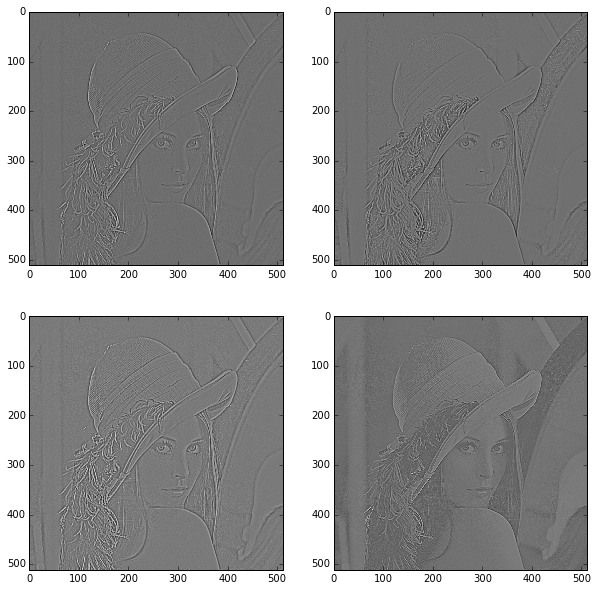

In [13]:
p = 3 # dont make it too big
grey_img_t = grey_img
patches = extract_patches(grey_img_t, (p,p))
n = len(patches)

np_patches = np.array(patches).reshape(n, p**2)
# centering expects X = [m, n] array
centered_patches = centering(np_patches.T).T.reshape(n, p, p)
contrast_normalised = contrast_normalization(np_patches.T).T.reshape(n, p, p)
combined = contrast_normalization(centered_patches.T).T.reshape(n, p, p)

# Centering
plt.figure(figsize=(10,10))
plt.subplot(221)
img = assemble_patches(centered_patches,grey_img_t.shape)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = assemble_patches(contrast_normalised,grey_img_t.shape)
plt.subplot(222)
plt.imshow(img, cmap=plt.get_cmap('gray'))

# Centering + l2 normalization
img = assemble_patches(combined,grey_img_t.shape)
plt.subplot(223)
plt.imshow(img, cmap=plt.get_cmap('gray'))

# Whiten Data
index_array = np.arange(len(np_patches))
rand.shuffle(index_array)
np_patches[index_array[0:100]]
data = np_patches[::100]
data = data.reshape(len(data),p**2).T
T = whitening(data)
whitened = np.dot(T,np_patches.T).T.reshape(len(np_patches),p,p)
img = assemble_patches(whitened, grey_img_t.shape)
plt.subplot(224)
plt.imshow(img, cmap=plt.get_cmap('gray'))

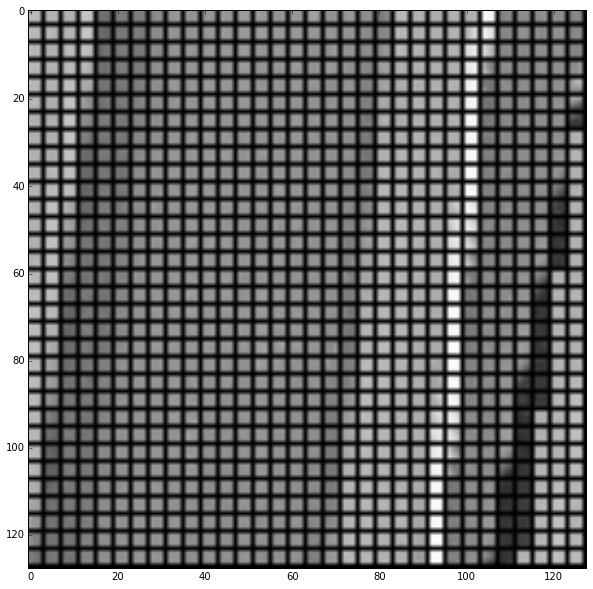

In [20]:
np_patche_array = np.array(patches)[::16]
vis = visualise_patches(np_patche_array,(512/16,512/16),padding=True)
plt.figure(figsize=(10,10))
plt.imshow(vis, cmap=plt.get_cmap('gray'))